# Training a Neural Net

In [1]:
import os
import sys
import numpy
import math
import caffe

from pprint import pprint
from pylab import *
%matplotlib inline

import pandas as pd

# helper to show images in square
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0, canvas=plt):
    for im in data:
        pass
        #im -= im.min()
        #im /= im.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    if data.ndim == 4:
        canvas.imshow(data)
    else:
        canvas.imshow(data, cmap='gray')
        
# Grab descriptions of the labels
classes = pd.read_csv('temp/class-list.csv', index_col='label', header=0)
print(classes)

caffe.set_device(0)
caffe.set_mode_gpu()

TRAIN_BATCH = 128
TEST_BATCH = 128

                        description
label                              
0                           No Data
1                        Open Water
2                Perennial Ice/Snow
3             Developed; Open Space
4          Developed; Low Intensity
5       Developed; Medium Intensity
6          Developed High Intensity
7      Barren Land (Rock/Sand/Clay)
8                  Deciduous Forest
9                  Evergreen Forest
10                     Mixed Forest
11                      Dwarf Scrub
12                      Shrub/Scrub
13             Grassland/Herbaceous
14                 Sedge/Herbaceous
15                          Lichens
16                             Moss
17                      Pasture/Hay
18                 Cultivated Crops
19                   Woody Wetlands
20     Emergent Herbaceous Wetlands


In [2]:
def define_solver(base_lr, lr_step, gamma, weight_decay, **kwargs):
    return """# Generated from python.
    # Train Set
    #
    # Training net
    train_net: "temp/auto-train.prototxt"
    # Test net
    test_net: "temp/auto-test.prototxt"
    # These numbers don't matter, because we're running the test net ourselves.
    test_iter: 1
    test_interval: 100000
    # The base learning rate, momentum and the weight decay of the network.
    base_lr: %(base_lr)s
    momentum: 0.9
    weight_decay: %(weight_decay)s
    # The learning rate policy
    lr_policy: "step"
    gamma: %(gamma)f
    stepsize: %(lr_step)i
    display: 1000
    # The maximum number of iterations
    max_iter: 10000
    # snapshot intermediate results
    # snapshot: 1000
    # snapshot_prefix: "snap/lenet-2"
    # solver mode: CPU or GPU
    solver_mode: GPU""" % locals()

from caffe import layers as L
from caffe import params as P

def define_net(lmdb, lmdb_labels, batch_size, mean_file, fc_units=500, **kwargs):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    transform_param={
        'scale': 1./255,
        'mean_file': mean_file
    }
    n.data = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=transform_param, ntop=1)
    n.labels = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb_labels, ntop=1)
    
    n.conv1 = L.Convolution(n.data, kernel_size=7, stride=3, num_output=20, weight_filler=dict(type='xavier'))
    # n.relu1 = L.ReLU(n.conv1)
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.norm1 = L.LRN(n.pool1, alpha=0.0001, beta=0.75)
    
    n.conv2 = L.Convolution(n.norm1, kernel_size=5, pad=2, num_output=40, weight_filler=dict(type='xavier'))
    # n.relu2 = L.ReLU(n.conv2)
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=1, pool=P.Pooling.MAX)
    n.norm2 = L.LRN(n.pool2, alpha=0.0001, beta=0.75)

    n.conv3 = L.Convolution(n.norm2, kernel_size=3, pad=1, num_output=80, weight_filler=dict(type='xavier'))
    # n.relu3 = L.ReLU(n.conv3)
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.norm3 = L.LRN(n.pool3, alpha=0.0001, beta=0.75)

    n.ip1 = L.InnerProduct(n.norm3, num_output=fc_units, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    
    n.ip2 = L.InnerProduct(n.relu1, num_output=21, weight_filler=dict(type='xavier'))
    
    n.reshape_labels = L.Reshape(n.labels, shape={'dim': [0,0]})
    n.loss = L.SigmoidCrossEntropyLoss(n.ip2, n.reshape_labels)
    n.pred = L.Sigmoid(n.ip2)
    return n.to_proto()

## Set up the network
def create_solver(train_data, train_labels, **kwargs):
    with open('temp/autosolver.prototxt', 'w') as f:
        f.write(define_solver(**kwargs))

    with open('temp/auto-train.prototxt', 'w') as f:
        f.write('name: "SeedNet"\n')
        f.write(str(define_net(train_data, train_labels, TRAIN_BATCH,
                               train_data + '_mean.binaryproto',
                              **kwargs)))

    with open('temp/auto-test.prototxt', 'w') as f:
        f.write('name: "SeedNet"\n')
        f.write(str(define_net('temp/learnsat-val-lmdb',
                               'temp/classify/val-labels-lmdb',
                               TEST_BATCH,
                               train_data + '_mean.binaryproto',
                              **kwargs)))

        
    solver = caffe.SGDSolver('temp/autosolver.prototxt')
    
    blob = caffe.proto.caffe_pb2.BlobProto()
    data = open( train_data + '_mean.binaryproto' , 'rb' ).read()
    blob.ParseFromString(data)
    arr = np.array( caffe.io.blobproto_to_array(blob) )
    mean_image = arr[0]

    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': solver.net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', mean_image)
    transformer.set_input_scale('data', 1./255)
    
    return solver, transformer


import sklearn.metrics as metrics
def run_test(net, iterations):
    y_true = []
    y_pred = []
    for test_it in range(iterations):
        net.forward()
        y_pred.extend(net.blobs['pred'].data.argmax(1))
        y_true.extend(net.blobs['reshape_labels'].data.argmax(1))
    
    accuracy_score = metrics.accuracy_score(y_true, y_pred)
    precision_score = metrics.precision_score(y_true, y_pred, average='macro')
    recall_score = metrics.recall_score(y_true, y_pred, average='macro')
    
    return accuracy_score, precision_score, recall_score


def run(n_epochs=30, train_size=None, **kwargs):
    TRAIN_DATA = 'temp/learnsat-subset-' + str(train_size) + '-train-lmdb'
    TRAIN_LABELS = 'temp/classify/train-' + str(train_size) + '-labels-lmdb'
    TEST_SIZE = 2048
    TEST_EPOCH = TEST_SIZE / TEST_BATCH

    train_epoch = train_size / TRAIN_BATCH
    
    params = kwargs
    # convert lr_step from iterations to epochs
    params['lr_step'] = params['lr_step'] * train_epoch

    solver, transformer = create_solver(TRAIN_DATA,
                                        TRAIN_LABELS,
                                       **params)

    niter = train_epoch * n_epochs + 1
    test_interval = train_epoch
    ntest = 1 + int(np.ceil(float(niter-1) / test_interval))
    # losses will also be stored in the log
    train_loss = zeros(niter)
    train_acc = zeros(ntest)
    train_precision = zeros(ntest)
    train_recall = zeros(ntest)
    test_acc = zeros(ntest)
    test_precision = zeros(ntest)
    test_recall = zeros(ntest)
    output = zeros((niter, 16, 21))

    # the main solver loop
    for it in range(niter):
        solver.step(1)  # SGD by Caffe

        # store the train loss
        train_loss[it] = solver.net.blobs['loss'].data

        # run a full test every so often
        # (Caffe can also do this for us and write to a log, but we show here
        #  how to do it directly in Python, where more complicated things are easier.)
        if it % test_interval == 0:
            index = it // test_interval
            test_acc[index], test_precision[index], test_recall[index] = run_test(solver.test_nets[0], TEST_EPOCH)
            train_acc[index], train_precision[index], train_recall[index] = run_test(solver.net, train_epoch)
            
    return (params,
        niter,
        train_epoch,
        test_interval,
        train_loss,
        train_acc,
        train_precision,
        train_recall,
        test_acc,
        test_precision,
        test_recall)


def plot_result(params,
        niter,
        train_epoch,
        test_interval,
        train_loss,
        train_acc,
        train_precision,
        train_recall,
        test_acc,
        test_precision,
        test_recall):
    
    fig, (ax1, bx1) = subplots(1, 2, figsize=(12,5))
    fig.suptitle(str(params))
    ax2 = ax1.twinx()
    ax1.plot(arange(niter) / float(train_epoch), train_loss)
    ax2.plot(test_interval * arange(len(test_acc)) / train_epoch, test_acc, 'r',
             test_interval * arange(len(train_acc)) / train_epoch, train_acc, 'g')
    #ax3 = ax2.twinx()
    #ax3.plot(test_interval * arange(len(test_acc)), train_acc, 'g')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('train loss')
    ax1.set_ylim((0,16))
    ax2.set_ylabel('accuracy')
    ax2.set_ylim((0,1))
    #ax3.set_ylabel('test accuracy')

    fscore = test_precision * test_recall / (test_precision + test_recall)
    bx2 = bx1.twinx()
    bx1.plot(arange(niter), train_loss)
    bx2.plot(test_interval * arange(len(test_acc)), test_precision, 'r',
             test_interval * arange(len(train_acc)), test_recall, 'y',
             test_interval * arange(len(train_acc)), fscore, 'g')
    #ax3 = ax2.twinx()
    #ax3.plot(test_interval * arange(len(test_acc)), train_acc, 'g')
    bx1.set_xlabel('iteration')
    bx1.set_ylabel('train loss')
    bx1.set_ylim((0,None))
    bx2.set_ylabel('precision, recall, fscore')
    bx2.set_ylim((0,1))
    #ax3.set_ylabel('test accuracy')
    return fig

In [ ]:
params = [
    dict(
        base_lr=lr,
        weight_decay=lamb,
        gamma=gamma,
        lr_step=20,
        train_size=N,
        fc_units=fc_units
    )
    for fc_units in [400]
    for gamma in [1, 0.5, 0.1]
    for lamb in [0.005, 0.001, 0.0005, 0.0001, 0]
    for N in [10240]
    for lr in [0.01, 0.001]
]

results = []

print('Running ' + str(len(params)) + ' configurations.')
for p in params:
    print(' - Config: ' + str(p))
    res = run(n_epochs=120, **p)
    results.append(res)
    print('   ...finished, ran ' + str(res[1]) + ' iterations')

print('Done with all configurations.')

Running 30 configurations.
 - Config: {'lr_step': 20, 'train_size': 10240, 'base_lr': 0.01, 'fc_units': 400, 'weight_decay': 0.005, 'gamma': 1}
   ...finished, ran 9601 iterations
 - Config: {'lr_step': 20, 'train_size': 10240, 'base_lr': 0.001, 'fc_units': 400, 'weight_decay': 0.005, 'gamma': 1}
   ...finished, ran 9601 iterations
 - Config: {'lr_step': 20, 'train_size': 10240, 'base_lr': 0.01, 'fc_units': 400, 'weight_decay': 0.001, 'gamma': 1}
   ...finished, ran 9601 iterations
 - Config: {'lr_step': 20, 'train_size': 10240, 'base_lr': 0.001, 'fc_units': 400, 'weight_decay': 0.001, 'gamma': 1}
   ...finished, ran 9601 iterations
 - Config: {'lr_step': 20, 'train_size': 10240, 'base_lr': 0.01, 'fc_units': 400, 'weight_decay': 0.0005, 'gamma': 1}
   ...finished, ran 9601 iterations
 - Config: {'lr_step': 20, 'train_size': 10240, 'base_lr': 0.001, 'fc_units': 400, 'weight_decay': 0.0005, 'gamma': 1}
   ...finished, ran 9601 iterations
 - Config: {'lr_step': 20, 'train_size': 10240, 'b

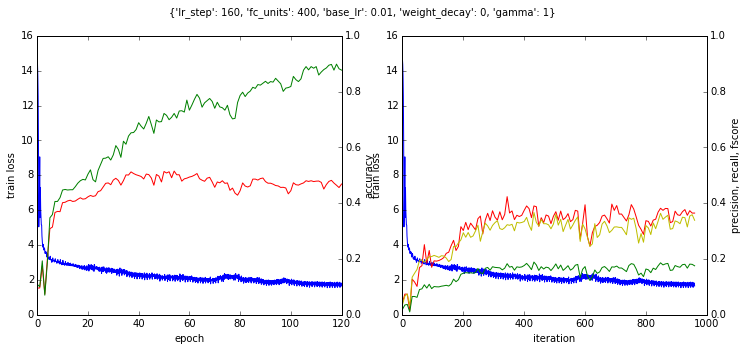

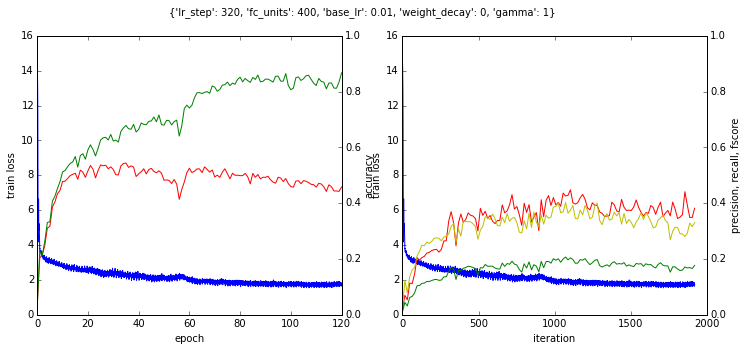

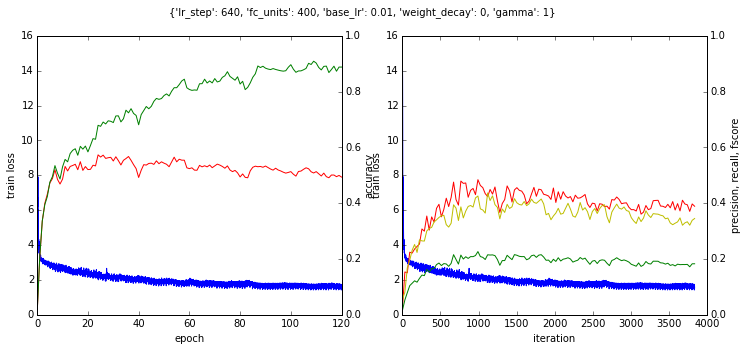

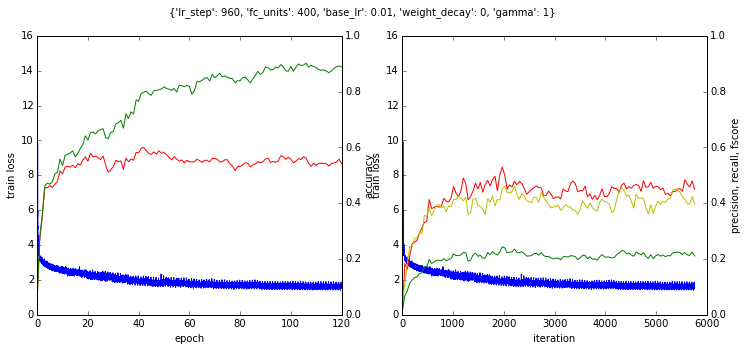

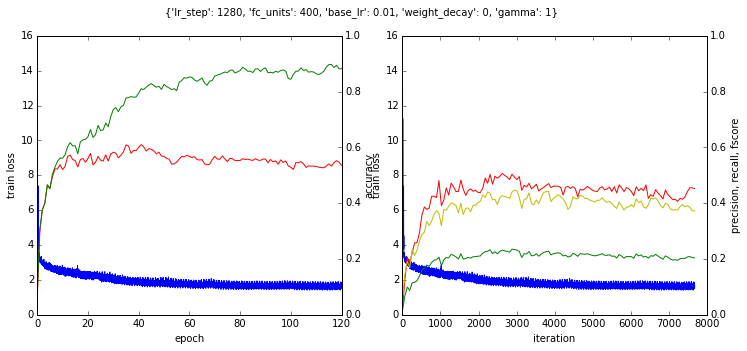

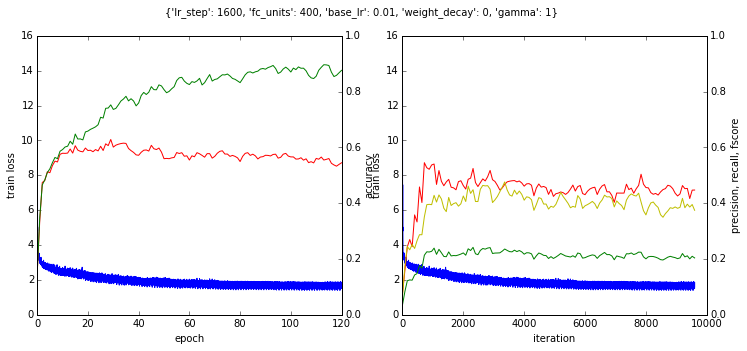

In [11]:
[plot_result(*result) for result in results]
#plot_result(results[0][0], 401, *results[0][1:])

In [ ]:
from shutil import copyfile

results_file = 'results/lenet-2.2nd-try'
if os.path.exists(results_file + '_train_loss.npy'):
    print('File exists! NOT saving!')
else:
    numpy.save(results_file + '_train_loss.npy', train_loss)
    numpy.save(results_file + '_train_acc.npy', train_acc)
    numpy.save(results_file + '_test_acc.npy', test_acc)
    fig.savefig(results_file + '_plot.png')
    copyfile('temp/lenet_auto_train.prototxt', results_file + '_train.prototxt')
    copyfile('temp/autosolver.prototxt', results_file + '_solver.prototxt')

In [ ]:
labels = classes.index.tolist()
descriptions = classes.description.tolist()
def report(net, iterations):
    y_true = []
    y_pred = []
    for test_it in range(iterations):
        net.forward()
        y_pred.extend(net.blobs['ip2'].data.argmax(1))
        y_true.extend(net.blobs['reshape_labels'].data.argmax(1))
    
    print(metrics.confusion_matrix(y_true, y_pred))
    print(metrics.classification_report(y_true, y_pred, labels, descriptions))

report(solver.net, TRAIN_EPOCH)

## Sanity Checks

After loading up a solver, run these checks to see if it's set up as expected.

In [27]:
solver, transformer = create_solver(
    'temp/learnsat-subset-' + str(1024) + '-train-lmdb',
    'temp/classify/train-' + str(1024) + '-labels-lmdb',
    **{'lr_step': 160, 'base_lr': 0.01, 'weight_decay': 0, 'gamma': 0.1, 'ip2_units': 500})

solver.net.forward()
# To get an idea of the architecture of our net, we can check the dimensions of 
# the intermediate features (blobs) and parameters (these will also be useful to 
# refer to when manipulating data later).

# each output is (batch size, feature dim, spatial dim)
pprint([(k, v.data.shape) for k, v in solver.net.blobs.items()])

# just print the weight sizes (not biases)
pprint([(k, v[0].data.shape) for k, v in solver.net.params.items()])

# now draw the network!
!$CAFFE_ROOT/python/draw_net.py --rankdir TB temp/auto-train.prototxt temp/net.png
from IPython.display import Image
#Image(filename='temp/net.png', width=300)

[('data', (128, 3, 128, 128)),
 ('labels', (128, 21, 1, 1)),
 ('conv1', (128, 20, 41, 41)),
 ('pool1', (128, 20, 21, 21)),
 ('norm1', (128, 20, 21, 21)),
 ('conv2', (128, 40, 21, 21)),
 ('pool2', (128, 40, 20, 20)),
 ('norm2', (128, 40, 20, 20)),
 ('conv3', (128, 80, 20, 20)),
 ('pool3', (128, 80, 10, 10)),
 ('norm3', (128, 80, 10, 10)),
 ('ip2', (128, 500)),
 ('ip3', (128, 21)),
 ('ip3_ip3_0_split_0', (128, 21)),
 ('ip3_ip3_0_split_1', (128, 21)),
 ('reshape_labels', (128, 21)),
 ('loss', ()),
 ('pred', (128, 21))]
[('conv1', (20, 3, 7, 7)),
 ('conv2', (40, 20, 5, 5)),
 ('conv3', (80, 40, 3, 3)),
 ('ip2', (500, 8000)),
 ('ip3', (21, 500))]
Couldn't import dot_parser, loading of dot files will not be possible.
Drawing net to temp/net.png


In [30]:
## Baseline accuracy.  Should be around 1 / number of classes
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)
print(solver.net.blobs['ip2'].data[0])
print(solver.net.blobs['reshape_labels'].data[0])
print(solver.net.blobs['loss'].data)
# run an initial forward pass for the full dataset, and see what kind of results we get.
# accuracy should be ~ 1/num-classes
print(run_test(solver.net, 1024 / TRAIN_BATCH))
print(run_test(solver.test_nets[0], 2048 / TEST_BATCH))

[ 0.          0.          0.          0.02956623  0.04879009  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.09034945  0.          0.          0.          0.08052851
  0.06865951  0.10465332  0.0043578   0.06616747  0.          0.00738166
  0.07005418  0.0605831   0.          0.          0.          0.          0.
  0.          0.05624295  0.          0.          0.          0.00570396
  0.00082958  0.          0.02838362  0.          0.          0.
  0.00969112  0.01425791  0.          0.          0.04035418  0.          0.
  0.          0.          0.          0.06298486  0.          0.
  0.05835364  0.06810173  0.          0.04378141  0.06633512  0.03622817
  0.          0.          0.          0.          0.          0.00379876
  0.01603146  0.          0.03448873  0.          0.07673959  0.
  0.06049709  0.03427337  0.          0.          0.          0.0587123
  0.00931443  0.          0.          0.00759113  0.        

In [31]:
print(solver.net.blobs['pred'].data[0])
print(solver.net.blobs['reshape_labels'].data[0])

[ 0.50848222  0.49630743  0.50736099  0.48467094  0.49372622  0.5003404
  0.49740306  0.49818096  0.48866493  0.47458056  0.49076879  0.49897501
  0.49754956  0.49267685  0.49758345  0.50309473  0.51068676  0.50786352
  0.49946806  0.50118512  0.50283676]
[ 0.          0.          0.          0.05926514  0.08837891  0.01800537
  0.00183105  0.          0.09820557  0.02154541  0.00512695  0.          0.
  0.          0.          0.          0.          0.27545166  0.43023682
  0.00195312  0.        ]


Are we loading train and test images, and their labels?

,No Data,Open Water,Perennial Ice/Snow,Developed; Open Space,Developed; Low Intensity,Developed; Medium Intensity,Developed High Intensity,Barren Land (Rock/Sand/Clay),Deciduous Forest,Evergreen Forest,...,Dwarf Scrub,Shrub/Scrub,Grassland/Herbaceous,Sedge/Herbaceous,Lichens,Moss,Pasture/Hay,Cultivated Crops,Woody Wetlands,Emergent Herbaceous Wetlands
0,0,0.000000,0,0.059265,0.088379,0.018005,0.001831,0.000000,0.098206,0.021545,...,0,0.000000,0.000000,0,0,0,0.275452,0.430237,0.001953,0.000000
1,0,0.000000,0,0.015442,0.005737,0.000000,0.000000,0.000000,0.000000,0.667969,...,0,0.277588,0.025940,0,0,0,0.000000,0.000000,0.004150,0.003174
2,0,0.078857,0,0.149170,0.173218,0.091309,0.013245,0.000671,0.014221,0.000000,...,0,0.009949,0.002563,0,0,0,0.022156,0.173035,0.260193,0.011414
3,1,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000
4,0,0.885498,0,0.000061,0.000061,0.000000,0.000000,0.000854,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0.000000,0.023743,0.000122,0.089661
5,0,0.000000,0,0.057495,0.001160,0.000122,0.000000,0.000000,0.552246,0.000305,...,0,0.074097,0.008423,0,0,0,0.087036,0.173889,0.041809,0.000000
6,0,0.000000,0,0.001526,0.013062,0.000671,0.000000,0.000000,0.000000,0.482727,...,0,0.477112,0.010742,0,0,0,0.000000,0.000000,0.001160,0.013000
7,0,0.956970,0,0.001404,0.001038,0.001587,0.000000,0.003601,0.006592,0.000000,...,0,0.006592,0.007019,0,0,0,0.001282,0.001160,0.000000,0.012085
8,0,0.000366,0,0.282166,0.030029,0.007141,0.000793,0.000000,0.192383,0.000732,...,0,0.026367,0.001160,0,0,0,0.194580,0.234863,0.026245,0.001648
9,0,0.017700,0,0.079224,0.096436,0.279419,0.438110,0.021545,0.022034,0.036743,...,0,0.000000,0.000122,0,0,0,0.000000,0.001770,0.002686,0.003479


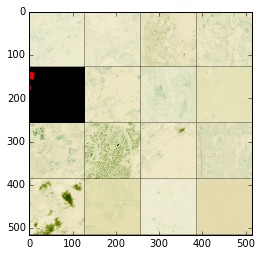

In [6]:
index = 0
count = 16
images = solver.net.blobs['data'].data[index:index+count]
images = numpy.array([transformer.deprocess('data', i) for i in images])
#images = images.transpose(0, 2, 3, 1)
vis_square(images, 1, 0)
labels = solver.net.blobs['reshape_labels'].data[index:index+count]
#classes[classes.label == 10].at[0,'description']
#classes.reindex()
pd.DataFrame(labels, columns=classes['description'].tolist())

,No Data,Open Water,Perennial Ice/Snow,Developed; Open Space,Developed; Low Intensity,Developed; Medium Intensity,Developed High Intensity,Barren Land (Rock/Sand/Clay),Deciduous Forest,Evergreen Forest,...,Dwarf Scrub,Shrub/Scrub,Grassland/Herbaceous,Sedge/Herbaceous,Lichens,Moss,Pasture/Hay,Cultivated Crops,Woody Wetlands,Emergent Herbaceous Wetlands
0,0,0.191162,0,0.025879,0.010071,0.004639,0.000488,0.000000,0.000000,0.032288,...,0,0.447937,0.198547,0,0,0,0.088989,0.000000,0.000000,0.000000
1,0,0.000000,0,0.010498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.673401,0.028137,0,0,0,0.047363,0.240601,0.000000,0.000000
2,0,0.000000,0,0.076233,0.010010,0.001160,0.000061,0.000000,0.226196,0.022705,...,0,0.059937,0.004639,0,0,0,0.249268,0.266418,0.071777,0.000000
3,0,0.418396,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,0.581604
4,0,0.394348,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000122,0,0,0,0.000000,0.000000,0.000793,0.604736
5,0,0.000000,0,0.026733,0.000427,0.000000,0.000000,0.000000,0.000977,0.000000,...,0,0.278442,0.005676,0,0,0,0.000000,0.687744,0.000000,0.000000
6,1,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000
7,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000
8,0,0.000000,0,0.127075,0.061646,0.010620,0.000610,0.003296,0.322327,0.017517,...,0,0.054626,0.004822,0,0,0,0.040527,0.157654,0.175781,0.004089
9,0,0.000000,0,0.018188,0.030640,0.005615,0.000000,0.000854,0.000000,0.601074,...,0,0.243103,0.064514,0,0,0,0.021362,0.000000,0.005798,0.008850


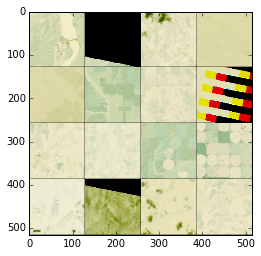

In [7]:
images = solver.test_nets[0].blobs['data'].data[:16]
images = numpy.array([transformer.deprocess('data', i) for i in images])
vis_square(images)
labels = solver.test_nets[0].blobs['reshape_labels'].data[index:index+count]
#classes[classes.label == 10].at[0,'description']
#classes.reindex()
classes = pd.read_csv('temp/class-list.csv', index_col='label', header=0)
classes.at[2,'description']
pd.DataFrame(labels, columns=classes['description'].tolist())

Both train and test nets seem to be loading data, and to have correct labels. Let's take one step of (minibatch) SGD and see what happens.

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

In [ ]:
solver.step(1)
print(solver.net.params['conv1'][0].diff[:, 0].shape)
vis_square(solver.net.params['conv1'][0].diff[:, 0])

## Visualizing Filters

After some training, we can visualize what the filters of our convnet look like, and what kinds of outputs they produce

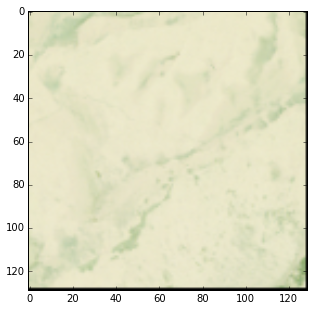

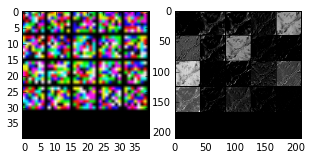

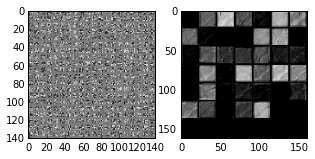

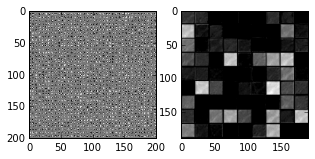

In [32]:
index = 0
plt.rcParams['figure.figsize'] = (5,5)
figure()
vis_square(numpy.array([transformer.deprocess('data', solver.net.blobs['data'].data[index])]))

fig, (ax1, ax2) = subplots(1, 2)
filters = solver.net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1), 1, 0, ax1)
images = solver.net.blobs['ReLU1'].data[index]
vis_square(images, 1, 0, ax2)

fig, (ax1, ax2) = subplots(1, 2)
vis_square(solver.net.params['conv2'][0].data[:20].reshape(20**2, 5, 5), 2, 0, ax1)
vis_square(solver.net.blobs['relu2'].data[index], 2, 0, ax2)

fig, (ax1, ax2) = subplots(1, 2)
vis_square(solver.net.params['conv3'][0].data[:40].reshape(40**2, 3, 3), 2, 0, ax1)
vis_square(solver.net.blobs['relu3'].data[index], 1, 0, ax2)
